In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor as rf
import xgboost as xgb
import math
import warnings
import model.visualset
warnings.filterwarnings('ignore')

In [6]:
model.visualset.Graphset()

In [7]:
# data load
all_df = pd.read_csv('../data/smart_farm.csv')
all_df = all_df.iloc[:,1:]

In [8]:
for colname in all_df.columns:
    newName = colname[11:]
    print(newName)
    all_df.rename(columns={colname:newName},inplace=True)

yy
mm
dd
hh
nn
insolation
out_tmperature
out_humidity
wind_speed
wind_direction
in_tmperature
in_humidity
shield_light_h
shield_tmperature_h
shield_energy_h
shield_energy_v
exhaust_fan
ceiling
floating_fan
fan_coil_b_site
ventilation_temperature_control
heating_temperature_set_up
heat_supply


In [9]:
# 날짜 Index가 여러개 있어서 하나로 정리하고싶을 때 실행
# date = all_df[['yy','mm','dd','hh','nn']].astype(str).apply('-'.join,axis=1)
date = all_df[['yy','mm','dd']].astype(str).apply('-'.join,axis=1)
time = all_df[['hh','nn']].astype(str).apply(':'.join,axis=1)
datetime = date + ' ' + time
all_df.insert(loc=0,column='date',value=datetime)
all_df['date'] = pd.to_datetime(all_df['date'])

In [10]:
all_df['date'].value_counts().sort_values()

2021-11-26 00:00:00    1
2021-11-26 00:08:00    1
2021-11-26 00:02:00    1
2021-11-26 00:03:00    1
2021-11-26 00:04:00    1
                      ..
2022-03-20 23:52:00    1
2022-03-20 23:53:00    1
2022-03-20 23:54:00    1
2022-03-20 23:56:00    1
2022-03-20 23:59:00    1
Name: date, Length: 152640, dtype: int64

In [11]:
all_df['heat_supply'].isnull().sum()

21177

<AxesSubplot:xlabel='date'>

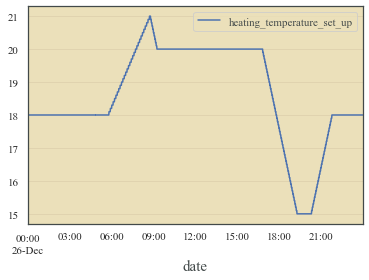

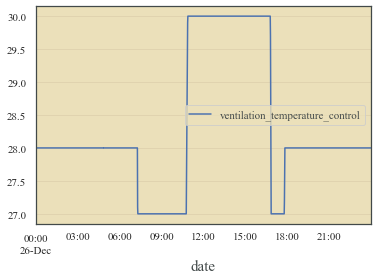

In [12]:
graph_df = all_df[all_df['date'].between('2021-12-26 00:00:00', '2021-12-26 23:59:59')]
graph_df[['date','out_tmperature','out_humidity','in_humidity','ventilation_temperature_control','heating_temperature_set_up','in_tmperature','out_tmperature','ceiling','heat_supply','insolation']].plot(x='date',y='heating_temperature_set_up')
graph_df[['date','out_tmperature','out_humidity','ventilation_temperature_control','heating_temperature_set_up']].plot(x='date',y='ventilation_temperature_control')


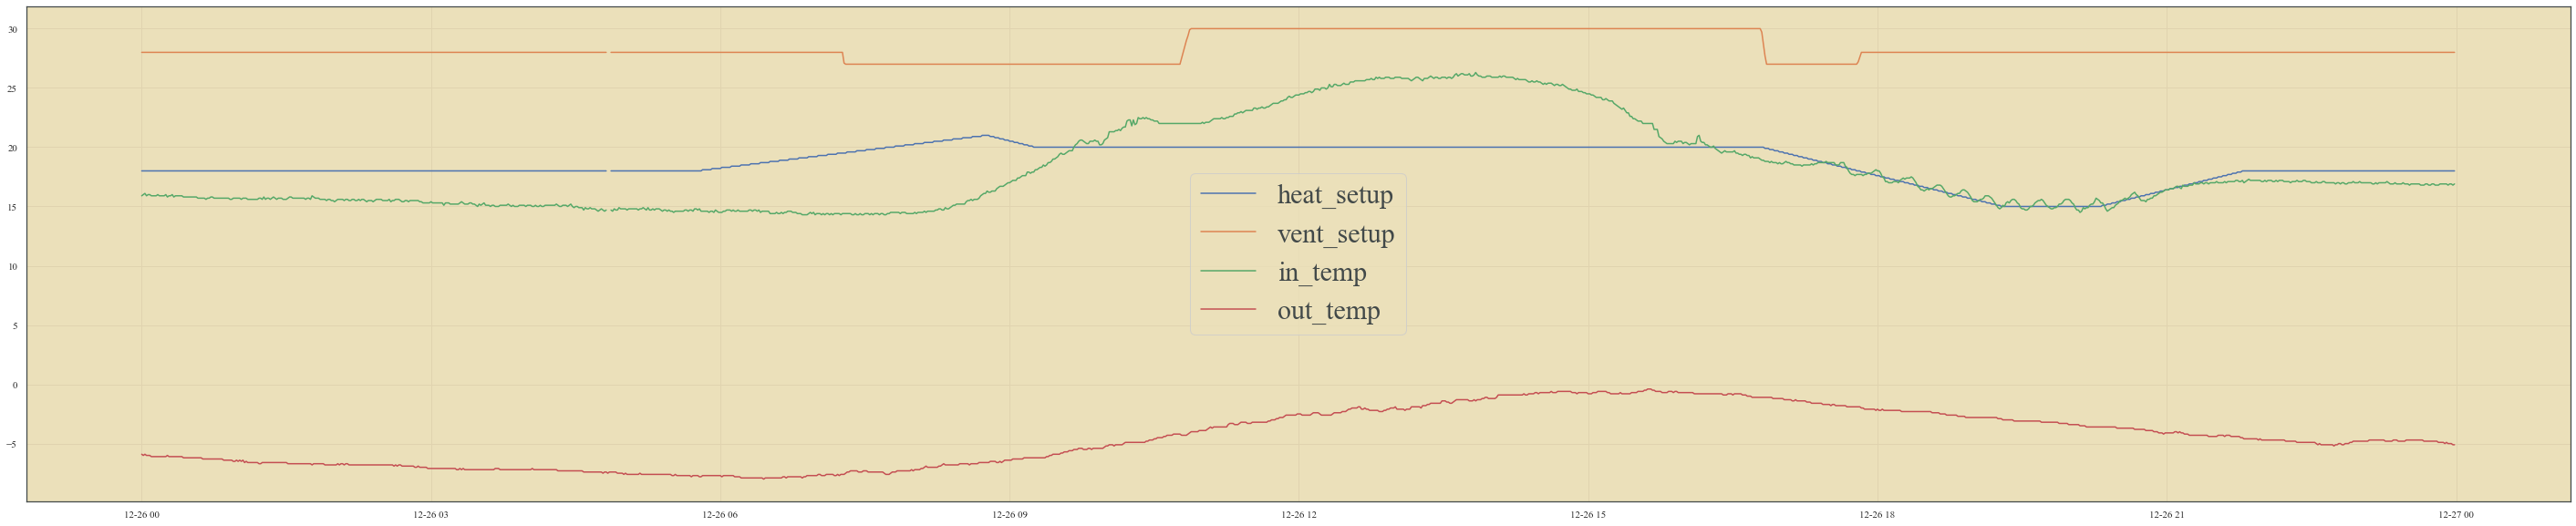

In [13]:
# plt.subplot(1,1,1)
plt.figure(figsize=(50,10))
plt.plot(graph_df['date'],graph_df['heating_temperature_set_up'])
plt.plot(graph_df['date'],graph_df['ventilation_temperature_control'])
plt.plot(graph_df['date'],graph_df['in_tmperature'])
plt.plot(graph_df['date'],graph_df['out_tmperature'])
# plt.plot(graph_df['date'],graph_df['in_humidity'])
plt.legend(['heat_setup','vent_setup','in_temp','out_temp'], prop={'size':30})
# plt.plot(graph_df['date'],graph_df['out_tmperature'])
# plt.plot(graph_df['date'],graph_df['ceiling'])
# plt.plot(graph_df['date'],graph_df['heat_supply'])
    

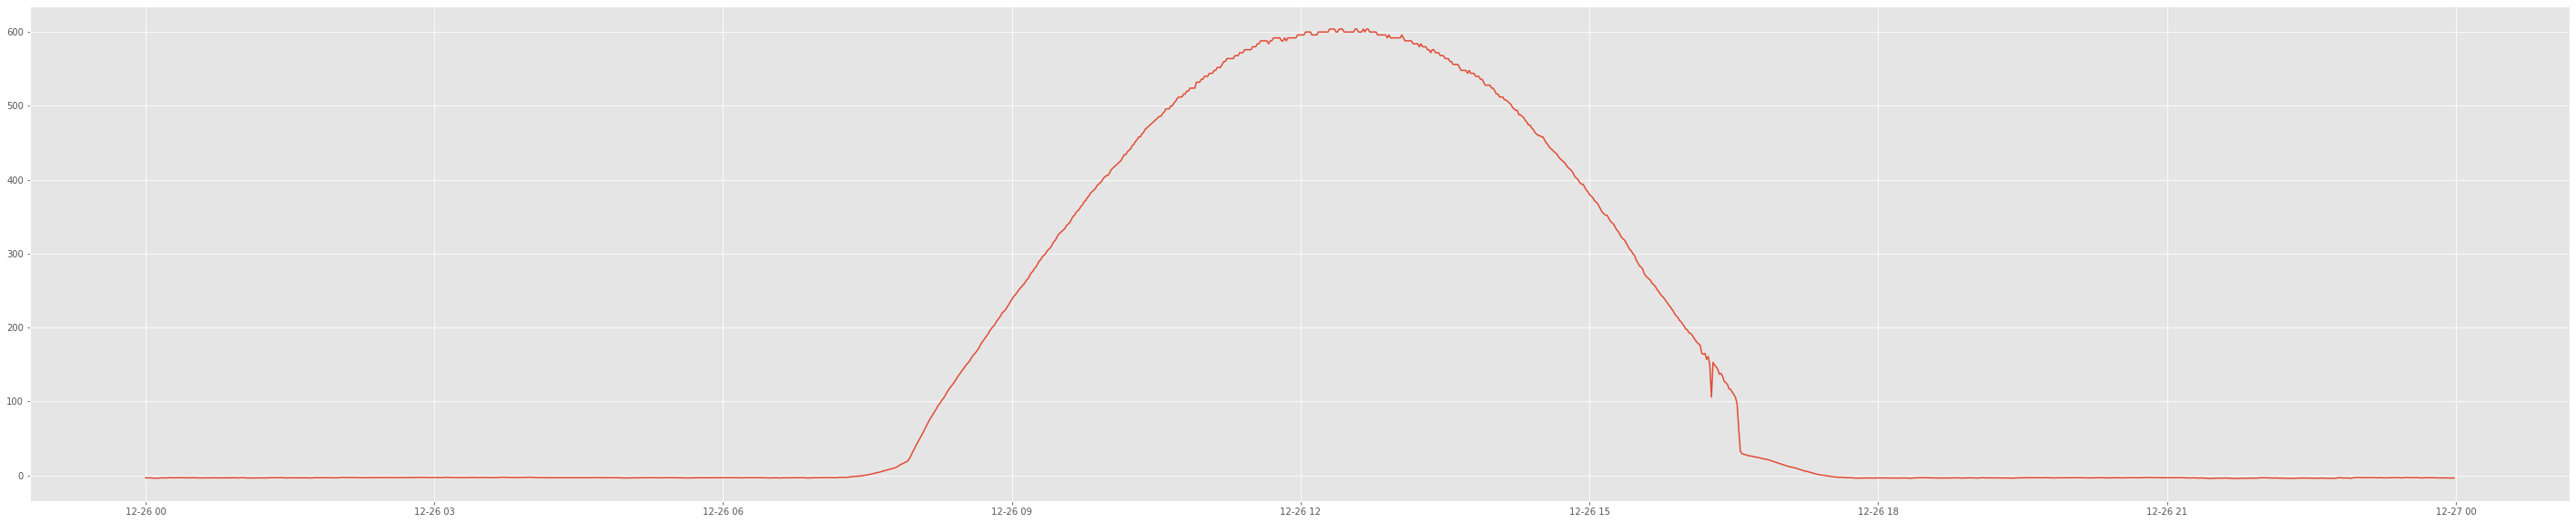

In [18]:
plt.figure(figsize=(50,10))
plt.plot(graph_df['date'],graph_df['insolation'])
plt.plot(graph_df['date'],graph_df['insolation'])

In [ ]:
all_df.head()

,date,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
0,2021-11-26,2021,11,26,0,0,-2.7,5.8,67,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
1,2021-11-26,2021,11,26,0,1,-2.9,5.8,67,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,0.9
2,2021-11-26,2021,11,26,0,2,-3.0,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.9
3,2021-11-26,2021,11,26,0,3,-3.0,5.7,67,1.3,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,0.8
4,2021-11-26,2021,11,26,0,4,-2.8,5.7,67,0.9,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1.0


In [ ]:
# 결측치 확인
all_df.isnull().sum()

date                                   0
yy                                     0
mm                                     0
dd                                     0
hh                                     0
nn                                     0
insolation                             0
out_tmperature                         0
out_humidity                           0
wind_speed                             0
wind_direction                         0
in_tmperature                        512
in_humidity                          512
shield_light_h                       512
shield_tmperature_h                  512
shield_energy_h                      512
shield_energy_v                      512
exhaust_fan                          512
ceiling                              512
floating_fan                         512
fan_coil_b_site                      512
ventilation_temperature_control      501
heating_temperature_set_up           500
heat_supply                        21075
dtype: int64

In [ ]:
all_df[all_df['heat_supply'].isnull()]['date'].value_counts()

2022-01-23    1440
2022-01-24    1440
2022-01-29    1440
2022-01-28    1440
2022-01-27    1440
2021-12-26    1440
2021-12-27    1440
2021-12-28    1440
2021-12-29    1440
2021-12-30    1440
2021-12-31    1440
2022-01-01    1440
2022-01-26    1440
2022-01-25    1440
2022-02-19     269
2022-02-26     240
2021-12-17      79
2022-01-20      62
2022-01-30      47
2022-02-12      31
2022-01-18      29
2021-12-15      23
2022-02-18      19
2022-02-20      17
2022-02-21      16
2022-02-22      14
2021-12-16      13
2021-12-19      12
2021-11-30      12
2022-02-07      12
2022-01-09       7
2022-01-10       5
2022-02-05       4
2021-11-27       4
Name: date, dtype: int64

In [ ]:
all_df.to_csv("data/all_df.csv",index=False)

In [ ]:
# 스마트팜 내부제어 요소 리스트
List_Control = ['shield_light_h','shield_tmperature_h','shield_energy_h','shield_energy_v','exhaust_fan','ceiling','floating_fan','fan_coil_b_site','heat_supply']

In [ ]:
all_df_corr = all_df.drop(['date'],axis=1)
all_df_corr = all_df_corr.corr()

In [ ]:
cont_df = all_df[List_Control]
cont_df_corr = cont_df.corr()

<AxesSubplot:>

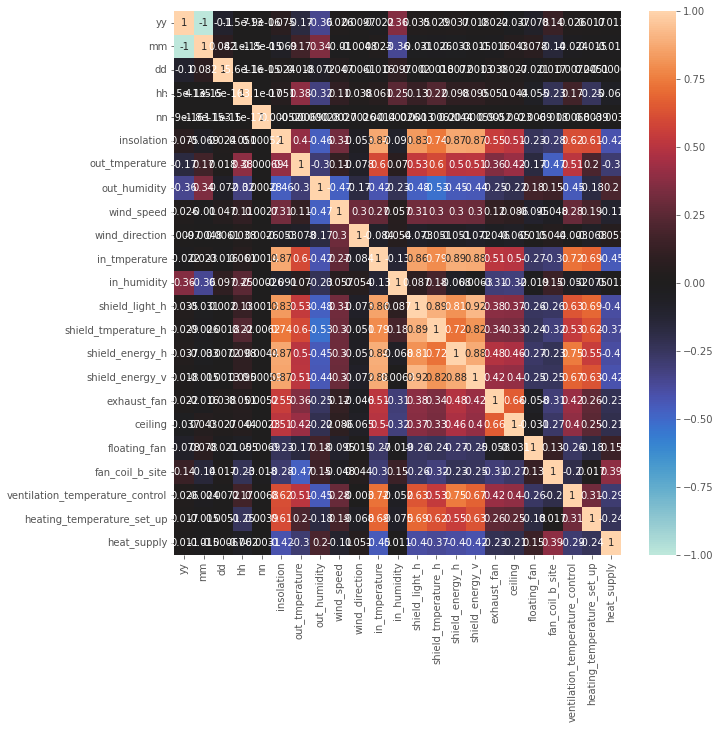

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(all_df_corr,vmax=1, vmin=-1, center=0, annot=True)

<AxesSubplot:>

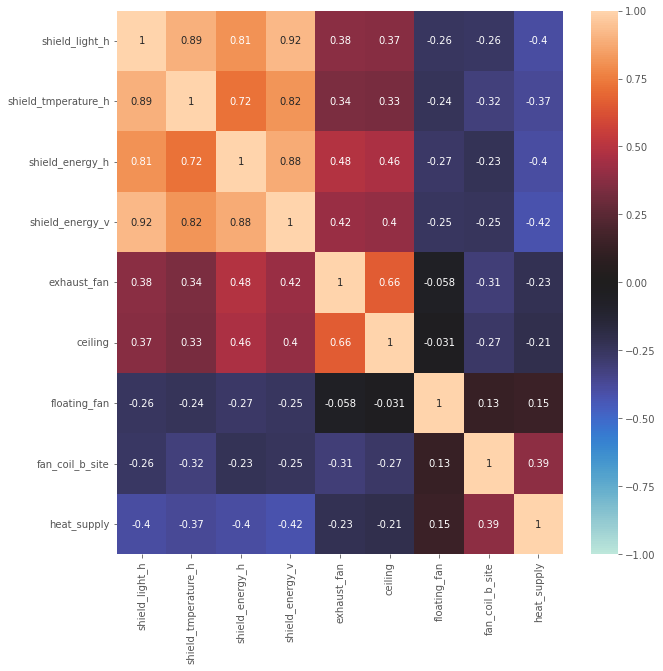

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(cont_df_corr,vmax=1, vmin=-1, center=0, annot=True)

In [ ]:
all_df_corr['heat_supply'].abs().sort_values(ascending=False)

heat_supply                        1.000000
in_tmperature                      0.447490
insolation                         0.419818
shield_energy_v                    0.417514
shield_energy_h                    0.398144
shield_light_h                     0.395033
fan_coil_b_site                    0.387514
shield_tmperature_h                0.371549
out_tmperature                     0.296630
ventilation_temperature_control    0.292799
heating_temperature_set_up         0.241718
exhaust_fan                        0.225630
ceiling                            0.206679
out_humidity                       0.199383
floating_fan                       0.148295
wind_speed                         0.107217
hh                                 0.061951
wind_direction                     0.051437
mm                                 0.015147
yy                                 0.011012
in_humidity                        0.010526
nn                                 0.003069
dd                              

<AxesSubplot:>

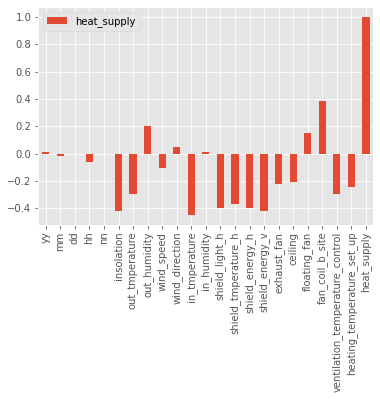

In [ ]:
all_df_corr.plot.bar(y='heat_supply')

In [ ]:
control_per_hour = all_df[['hh','shield_energy_h','shield_energy_v','fan_coil_b_site','shield_light_h','heat_supply']].groupby('hh').mean()
control_per_hour['heat_supply'] = control_per_hour['heat_supply'] * 60
control_per_hour

,shield_energy_h,shield_energy_v,fan_coil_b_site,shield_light_h,heat_supply
hh,,,,,
0,0.000000,0.000000,0.815580,0.000000,28.581081
1,0.000000,0.000000,0.832790,0.000000,27.817467
2,0.000000,0.000000,0.839312,0.000000,27.581908
3,0.000000,0.000000,0.853804,0.000000,28.127810
4,0.000000,0.000000,0.865672,0.000000,27.072856
5,0.000000,0.000000,0.892391,0.000000,27.587179
6,0.000000,0.000000,0.957586,0.000000,28.197812
7,0.000000,0.000000,0.972825,0.000000,28.260256
8,0.135091,11.908545,0.892727,25.797636,24.501282


In [ ]:
from model.train import trainer
from model.predict import predictor
import yaml
with open('model/setting/params.yml') as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
train_df = all_df.dropna()
train_df.to_csv('data/train_df.csv',index=False)

In [ ]:
train_X = train_df.drop(['date', 'heat_supply'],axis=1)
train_Y = train_df['heat_supply']

In [5]:
test1_df = all_df[all_df['date'].between('2022-03-04 00:00:00', '2022-03-13 23:59:59')]
test2_df = all_df[all_df['date'].between('2022-03-18 00:00:00', '2022-03-23 23:59:59')]

test1_df.to_csv("data/test1_df.csv",index=False)
test2_df.to_csv("data/test2_df.csv",index=False)

test1_X = test1_df.drop(['date', 'heat_supply'],axis=1)
test2_X = test2_df.drop(['date', 'heat_supply'],axis=1)

In [ ]:
test2_df.head()

,date,yy,mm,dd,hh,nn,insolation,out_tmperature,out_humidity,wind_speed,...,shield_tmperature_h,shield_energy_h,shield_energy_v,exhaust_fan,ceiling,floating_fan,fan_coil_b_site,ventilation_temperature_control,heating_temperature_set_up,heat_supply
79200,2022-01-23,2022,1,23,0,0,-2.7,3.0,72,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
79201,2022-01-23,2022,1,23,0,1,-2.7,3.0,72,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
79202,2022-01-23,2022,1,23,0,2,-2.7,3.0,72,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
79203,2022-01-23,2022,1,23,0,3,-2.8,3.0,72,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN
79204,2022-01-23,2022,1,23,0,4,-2.8,3.0,72,0.4,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,NaN


In [ ]:
tr = trainer()
pred = predictor()

tr.train_lgb(train_X, train_Y, params['lgb'])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 88620, number of used features: 22
[LightGBM] [Info] Start training from score 0.352127
[1]	valid_0's l2: 0.144859
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 0.143528
[3]	valid_0's l2: 0.142872
[4]	valid_0's l2: 0.140818
[5]	valid_0's l2: 0.139893
[6]	valid_0's l2: 0.137851
[7]	valid_0's l2: 0.136116
[8]	valid_0's l2: 0.135318
[9]	valid_0's l2: 0.134131
[10]	valid_0's l2: 0.133336
[11]	valid_0's l2: 0.131987
[12]	valid_0's l2: 0.131451
[13]	valid_0's l2: 0.131264
[14]	valid_0's l2: 0.131101
[15]	valid_0's l2: 0.130492
[16]	valid_0's l2: 0.13029
[17]	valid_0's l2: 0.130213
[18]	valid_0's l2: 0.13008
[19]	valid_0's l2: 0.129464
[20]	vali

In [ ]:
pred.predict_lgb(tr.models_lgb[0], test1_X)
pred.predict_lgb(tr.models_lgb[0], test2_X)

In [ ]:
submission = pd.read_csv('submit/submit.csv')

In [ ]:
submission.head()

,yy_from,mm_from,dd_from,yy_to,mm_to,dd_to,heat_supply_sum
0,2022,3,4,2022,3,13,NaN
1,2022,3,18,2022,3,23,NaN


In [ ]:
preds_ans1 = pred.preds_lgb[0].sum()
preds_ans2 = pred.preds_lgb[1].sum()

In [ ]:
submission['heat_supply_sum'] = np.array([preds_ans1,preds_ans2])

In [ ]:
submission.to_csv('submit/220156.csv',index=False)

In [ ]:

cont_df = all_df[List_Control]
cont_df = cont_df.dropna(axis=0)[List_Control]
cont_X = cont_df.iloc[:,:-1]
cont_y = cont_df.iloc[:,-1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(cont_X, cont_y, test_size = 0.2, random_state=1)
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_test_pred = model_linear.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = math.sqrt(mse)
print(rmse)


0.2782898764415272


In [ ]:
all_df[['heat_supply','fan_coil_b_site']].head(50)

,heat_supply,fan_coil_b_site
0,0.9,0.0
1,0.9,0.0
2,0.9,1.0
3,0.8,1.0
4,1.0,1.0
5,1.0,1.0
6,0.9,1.0
7,0.8,1.0
8,0.9,1.0
9,0.9,1.0
